# Graded Lab Assignment 2: Evaluate classifiers (10 points)
 
In this assignment you will optimize and compare the perfomance of a parametric (logistic regression) and non-parametric (k-nearest neighbours) classifier on the MNIST dataset.

Publish your notebook (ipynb file) to your Machine Learning repository on Github ON TIME. We will check the last commit on the day of the deadline.  

### Deadline Friday, November 17, 23:59.

This notebook consists of three parts: design, implementation, results & analysis. 
We provide you with the design of the experiment and you have to implement it and analyse the results.

### Criteria used for grading
* Explain and analyse all results.
* Make your notebook easy to read. When you are finished take your time to review it!
* You do not want to repeat the same chunks of code multiply times. If your need to do so, write a function. 
* The implementation part of this assignment needs careful design before you start coding. You could start by writing pseudocode.
* In this exercise the insights are important. Do not hide them somewhere in the comments in the implementation, but put them in the Analysis part
* Take care that all the figures and tables are well labeled and numbered so that you can easily refer to them.
* A plot should have a title and axes labels.
* You may find that not everything is 100% specified in this assignment. That is correct! Like in real life you probably have to make some choices. Motivate your choices.


### Grading points distribution

* Implementation 5 points
* Results and analysis 5 points

## Design of the experiment

You do not have to keep the order of this design and are allowed to alter it if you are confident.
* Import all necessary modules. Try to use as much of the available functions as possible. 
* Use the provided train and test set of MNIST dataset.
* Pre-process data eg. normalize/standardize, reformat, etc.           
  Do whatever you think is necessary and motivate your choices.
* (1) Train logistic regression and k-nn using default settings.
* Use 10-fold cross validation for each classifier to optimize the performance for one parameter: 
    * consult the documentation on how cross validation works in sklearn (important functions:             cross_val_score(), GridSearchCV()).
    * Optimize k for k-nn,
    * for logistic regression focus on the regularization parameter,
* (2) Train logistic regression and k-nn using optimized parameters.
* Show performance on the cross-validation set for (1) and (2) for both classifiers: 
    * report the average cross validation error rates (alternatively, the average accuracies - it's up to you) and standard deviation,
    * plot the average cross valildation errors (or accuracies) for different values of the parameter that you tuned. 
* Compare performance on the test set for two classifiers:
    * produce the classification report for both classifiers, consisting of precision, recall, f1-score. Explain and analyse the results.
    * print confusion matrix for both classifiers and compare whether they missclassify the same  classes. Explain and analyse the results.
* Discuss your results.
* BONUS: only continue with this part if you are confident that your implemention is complete 
    * tune more parameters of logistic regression
    * add additional classifiers (NN, Naive Bayes, decision tree), 
    * analyse additional dataset (ex. Iris dataset)

## Implementation of the experiment

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [55]:
# load all libraries and modules
from sklearn.datasets import load_digits
import numpy as np
from sklearn import datasets # to load the dataset
from sklearn.model_selection import train_test_split #to split in train and test set
from sklearn.model_selection import cross_val_score, GridSearchCV #BONUS
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix # for reporting
from scipy.spatial import distance #to calculate the Euclidean distance
from collections import Counter #to count unique occurances of items in array, for majority voting
from sklearn.preprocessing import StandardScaler # to normalize data (NN is very sensitive to this!)
from sklearn.neighbors import KNeighborsClassifier # k nearest neighbour classifier
from sklearn.neural_network import MLPClassifier # neural network classifier
from sklearn.linear_model import LogisticRegression #logistic regression classifier

In [3]:
# load mnist dataset and split in train and test set.
digits = datasets.load_digits()
X_train_mnist = np.reshape(digits.images[:1500],(1500,64))
X_test_mnist = np.reshape(digits.images[1500:],(297,64))
y_train_mnist = digits.target[:1500]
y_test_mnist = digits.target[1500:]


In [4]:
#preprocess data (normalisation)
scaler = StandardScaler()
scaler.fit(X_train_mnist)
scaler.fit(X_test_mnist)
normalised_X_train = scaler.transform(X_train_mnist)
normalised_X_test = scaler.transform(X_test_mnist)

In [5]:
#Train logistic regression and k-nn using default settings.
log_regr = LogisticRegression()
k_nn_classifier = KNeighborsClassifier()
log_regr.fit(normalised_X_train, y_train_mnist)
k_nn_classifier.fit(normalised_X_train, y_train_mnist)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [100]:
#Use 10-fold cross validation for each classifier to optimize the performance for one parameter:
#10-fold cross-validation, before tuning
log_val_error = cross_val_score(log_regr, normalised_X_train, y_train_mnist, scoring="accuracy", cv=10)
k_nn_val_error = cross_val_score(k_nn_classifier, normalised_X_train, y_train_mnist, scoring="accuracy", cv=10)
print("Before customisation, average accuracy of Log Reg: ", log_val_error.mean())
print("Before customisation, average accuracy of Knn: ", k_nn_val_error.mean())

Before customisation, average accuracy of Log Reg:  0.941446300269
Before customisation, average accuracy of Knn:  0.948266646885


In [107]:
#- Optimize k for k-nn with GridSearchCV
k_param = {'n_neighbors': np.arange(1, 20)} # number of k neighbours from 1 to 20
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid=k_param, cv=10)
grid_search_knn.fit(normalised_X_train, y_train_mnist)
best_K = grid_search_knn.best_params_['n_neighbors'] # best_params_ -> dictionary type property
# use grid_search_knn.cv_results_ to see detailed results

In [108]:
#tune lambda with GridSearchCV
lambda_param = {'C': [0.1, 0.01, 0.001, 1, 10, 100, 1000]} # regularisation params to be considered
log = LogisticRegression()
grid_search_log = GridSearchCV(log, param_grid=lambda_param, cv=10)
grid_search_log.fit(normalised_X_train, y_train_mnist)
best_C = grid_search_log.best_params_['C']

In [109]:
#Train logistic regression and k-nn using optimized parameters.
log_regr_customised = LogisticRegression(C=best_C)
knn_customised = KNeighborsClassifier(n_neighbors=best_K)
log_regr_customised.fit(normalised_X_train, y_train_mnist)
knn_customised.fit(normalised_X_train, y_train_mnist)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [110]:
#Show performance on the cross-validation set for (1) and (2) for both classifiers: 
#    * report the average cross validation error rates (alternatively, the average accuracies - it's up to you) 
#and standard deviation, after tuning
log_customised_val_error = cross_val_score(log_regr_customised, normalised_X_train, y_train_mnist, scoring="accuracy",cv=10)
knn_customised_val_error = cross_val_score(knn_customised, normalised_X_train, y_train_mnist, scoring="accuracy", cv=10)
print("After customisation, average accuracy for Log Reg: ", log_customised_val_error.mean(), ", standard deviation: ", np.std(log_customised_val_error))
print("After customisation, average accuracy for Knn: ", knn_customised_val_error.mean(), ", standard deviation: ", np.std(knn_customised_val_error))

After customisation, average accuracy for Log Reg:  0.942180286678 , standard deviation:  0.0191189588715
After customisation, average accuracy for Knn:  0.959534823035 , standard deviation:  0.0271404395113


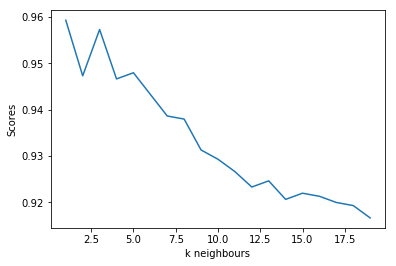

In [111]:
# plot the average cross valildation errors (or accuracies) for different values of k that you tuned. 
knn_plot = plt.plot(np.arange(1,20), grid_search_knn.cv_results_['mean_test_score'])
plt.xlabel('k neighbours')
plt.ylabel('Scores')

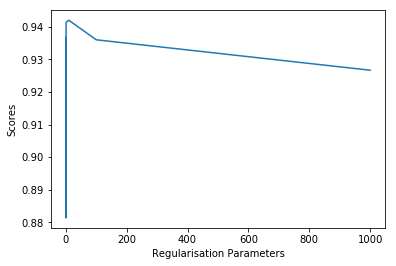

In [112]:
# plot the average cross valildation errors (or accuracies) for different values of lambdathat you tuned. 
log_plot = plt.plot(lambda_param['C'], grid_search_log.cv_results_['mean_test_score'])
plt.xlabel('Regularisation Parameters')
plt.ylabel('Scores')

In [113]:
#* Compare performance on the test set for two classifiers:
#    * produce the classification report for both classifiers, consisting of precision, recall, f1-score. 
log_predictions = log_regr_customised.predict(normalised_X_test)
knn_predictions = knn_customised.predict(normalised_X_test)
log_report = classification_report(y_test_mnist, log_predictions)
knn_report = classification_report(y_test_mnist, knn_predictions)
print("Logistic Regression's accuracy: ", accuracy_score(y_test_mnist, log_predictions))
print("Report for optimised Logistic Regression: \n", log_report)
print("Knn's accuracy: ", accuracy_score(y_test_mnist, knn_predictions))
print("Report for optimised K Nearest Neighbour: \n", knn_report)

Logistic Regression's accuracy:  0.878787878788
Report for optimised Logistic Regression: 
              precision    recall  f1-score   support

          0       0.96      0.93      0.94        27
          1       0.79      0.84      0.81        31
          2       1.00      1.00      1.00        27
          3       0.86      0.63      0.73        30
          4       0.91      0.91      0.91        33
          5       0.91      0.97      0.94        30
          6       0.97      0.97      0.97        30
          7       0.90      0.87      0.88        30
          8       0.68      0.89      0.77        28
          9       0.89      0.81      0.85        31

avg / total       0.89      0.88      0.88       297

Knn's accuracy:  0.929292929293
Report for optimised K Nearest Neighbour: 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00        27
          1       0.89      1.00      0.94        31
          2       1.00      0.89 

###    Explain and analyse Classification Reports
In the two classification reports above, what can be seen is the clearly better performance of the K Nearest Neighbour (KNN) classifier on all scoring categories (precision, recall and f1-score), and hence its accuracy score is also significantly higher (0.93 compared to Logistic Regression's (LR) 0.88). It's worth noting that the number of k-nearest-neighbours that was classified as best by the `GridSearchCV` module in the cross-validation phase was 1, this means that there is a clear separation of labels between the instances of the training set `X_train_mnist` (or `normalised_X_train`).

In the `precision` score ($tp/P$), while LR performed rather poorly in class 8 (0.68), KNN scored perfectly. The same thing can be seen with the `recall` score ($tp/(tp+fn)$) in class 3, where LR scored 0.63 and KNN scored 0.90.

In [114]:
# print confusion matrix for both classifiers and compare whether they missclassify the same  classes. 
log_cm = confusion_matrix(y_test_mnist, log_predictions)
knn_cm = confusion_matrix(y_test_mnist, knn_predictions)
print("Confusion matrix for Logistic Regression: \n", log_cm, "\n")
print("Confusion matrix for K Nearest Neighbours:\n", knn_cm)

Confusion matrix for Logistic Regression: 
 [[25  0  0  0  1  0  1  0  0  0]
 [ 0 26  0  2  0  0  0  0  3  0]
 [ 0  0 27  0  0  0  0  0  0  0]
 [ 0  1  0 19  0  3  0  2  5  0]
 [ 0  0  0  0 30  0  0  0  0  3]
 [ 0  1  0  0  0 29  0  0  0  0]
 [ 0  1  0  0  0  0 29  0  0  0]
 [ 0  0  0  0  1  0  0 26  3  0]
 [ 0  2  0  0  1  0  0  0 25  0]
 [ 1  2  0  1  0  0  0  1  1 25]] 

Confusion matrix for K Nearest Neighbours:
 [[27  0  0  0  0  0  0  0  0  0]
 [ 0 31  0  0  0  0  0  0  0  0]
 [ 0  0 24  0  0  0  3  0  0  0]
 [ 0  0  0 27  0  1  1  1  0  0]
 [ 0  0  0  0 29  0  0  1  0  3]
 [ 0  1  0  0  1 28  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  3  0  1  0  0  0  0 23  1]
 [ 0  0  0  1  0  2  0  1  0 27]]


### Explain and analyse Confusion Matrices
The two confusion matrices ($m x n$) above present the performances of two classifiers on the test set (`normalised_X_test`) that contains 10 classes (from 0 to 9). Their diagonals reflect the number of instances that were predicted correctly for each class. While for each entry $E$, $E_{i,j}$ is the number of instances that are supposed to be in class $i$ but were misclassified as class $j$. Looking at these 2 matrices, one can say that both classifiers misclassified class 3, 4, 5, 8 and 9. For example, in class 3, LR only correctly classified 19 instances, while 1 instance was misclassified as class 1, 3 as class 5, 2 as class 7 and 5 as class 8; hence the recall score of 0.63.

### Discuss your results.
The implementation of LR and KNN in this notebook indicates the following points:

 - Using cross validation to tune the parameters, specifically, k and lambda, did produce an improvement in the accuracy score of both classifiers. The best k was found to be 1, while the best regularisation parameter lambda was 10.
 - The reports and confusion matrices showed a better performance of the KNN classifier in the test set (normalised), with an average accuracy score of 0.93 in all scoring cateogories. Meanwhile, LR observed some low scores in class 3 for `recall` and 8 for `precision`.
 

In [115]:
#* BONUS: only continue with this part if you are confident that your implemention is complete 
#    * tune more parameters of logistic regression
#    * add additional classifiers (NN, Naive Bayes, decision tree), 
#    * analyse additional dataset (ex. Iris dataset)

## Results and analysis of the experiment

In [14]:
# discuss the results